<center>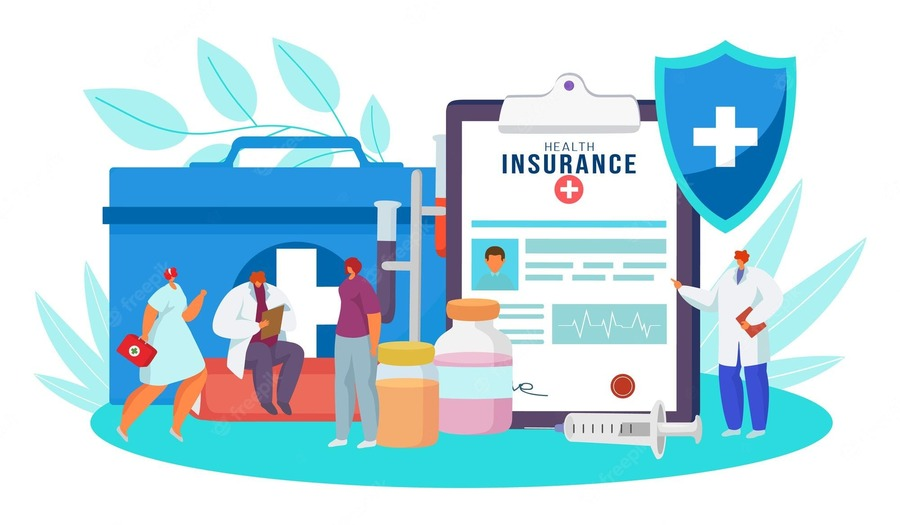</center>

The aim of this analysis is to investigate a range of health-related factors and their interconnections to predict individual medical costs billed by health insurance accurately. These factors include aspects such as age, gender, body mass index (BMI), number of children, smoking status, and region. This comprehensive examination will not only provide insights into the patterns and trends in health insurance charges but will also create a solid base for further research. Specifically, research can be built on how these variables interact and influence the cost of health insurance, crucial knowledge for improving insurance policy design and outcomes in this increasingly critical area of healthcare.



📄 **Project Contents**:

* [EDA (Exploratory Data Analysis)](#section-one)
* [Data Visualization](#section-two)
  1. [Uni-variate Analysis](#section-two)
    - [Categorical Analysis](#section-two)
    - [Numerical Analysis](#section-three)
  2. [Bi-variate Analysis](#section-four)
    - [Categorical vs Target](#section-four)
    - [Numerical vs Target](#section-five)
* [Feature Engineering](#section-six)
* [Model Building](#section-seven)
    1. [Optuna Hyper Parameter Optimization for Ensemble Models](#section-eight)
        - [LGBM Optuna](#section-nine)
        - [XGB Optuna](#section-ten)
        - [CatBoost Optuna](#section-eleven)
    2. [Build Optimized Models](#section-twelve)
    2. [Visual Comparing of Model Performances](#section-thirteen)
    3. [Final Model](#section-fourteen)
        - [Feature Importance with SHAP](#section-fifteen)
        - [Save Final Model](#section-sixteen)

---
1. **Age**: 
    * Age is a significant factor in health insurance as older individuals are generally at a higher risk of health issues compared to younger individuals. 
    * Therefore, age often correlates with higher insurance charges.
2. **Sex**: 
    * Gender can play a role in health insurance costs. Some studies suggest that women tend to use more health care services, especially during childbearing years. 
    * However, the impact of gender on health insurance charges can vary depending on other factors. 
3. **BMI** (Body Mass Index): 
    * BMI is a measure that attempts to quantify an individual's tissue mass. 
    * It's widely used as a simple method to assess whether a person has a healthy body weight for a given height. 
    * High BMI values are often associated with higher risk of chronic diseases, which can lead to higher health care costs.
4. **Children**: 
    * The number of dependents a person has can influence health insurance costs.
    * More dependents usually mean higher insurance charges because more individuals are covered under the same plan.
5. **Smoker**: 
    * Smoking is a significant risk factor for many health conditions, including heart disease, stroke, and cancer. 
    * Smokers often face higher health insurance charges due to these increased health risks.
6. **Region**: 
    * The region where the beneficiary lives can also affect health insurance charges. 
    * This could be due to variations in cost of living, health care costs, and health behaviors across different regions.
7. **Charges**: 
    * This is the individual medical costs billed by health insurance. 
    * It's the dependent variable in this dataset, and it's influenced by all the other factors.
    * Understanding the relationships between the independent variables (age, sex, bmi, children, smoker, region) and charges is the main goal of this analysis.


In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder, RobustScaler
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score

from sklearn.metrics import  mean_absolute_error, mean_squared_error, r2_score, make_scorer

from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor

from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

import joblib

import shap

In [2]:
df_original = pd.read_csv('/kaggle/input/insurance/insurance.csv')
df = df_original.copy()
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


<a name="section-one"></a>
# **EDA**

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [4]:
print(f'Shape     : {df.shape}\n'
      f'Size      : {df.size}\n'
      f'Dimension : {df.ndim}')

Shape     : (1338, 7)
Size      : 9366
Dimension : 2


In [5]:
df.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

In [6]:
df.duplicated().sum()

1

In [7]:
df.loc[df.duplicated(keep=False), :]

,age,sex,bmi,children,smoker,region,charges
195,19,male,30.59,0,no,northwest,1639.5631
581,19,male,30.59,0,no,northwest,1639.5631


In [8]:
df.drop_duplicates(inplace= True)

In [9]:
df.nunique()

age           47
sex            2
bmi          548
children       6
smoker         2
region         4
charges     1337
dtype: int64

In [10]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,1337.0,39.222139,14.044333,18.0000,27.000,39.0000,51.00000,64.00000
bmi,1337.0,30.663452,6.100468,15.9600,26.290,30.4000,34.70000,53.13000
children,1337.0,1.095737,1.205571,0.0000,0.000,1.0000,2.00000,5.00000
charges,1337.0,13279.121487,12110.359656,1121.8739,4746.344,9386.1613,16657.71745,63770.42801


In [11]:
df.corr(numeric_only=True).style.background_gradient(cmap='Blues', axis=0)  

,age,bmi,children,charges
age,1.000000,0.109344,0.041536,0.298308
bmi,0.109344,1.000000,0.012755,0.198401
children,0.041536,0.012755,1.000000,0.067389
charges,0.298308,0.198401,0.067389,1.000000


In [12]:
cat_cols = ['sex', 'smoker', 'region', 'children']
num_cols = ['age', 'bmi']
target_col = 'charges'

In [13]:
for col in cat_cols:
    print(pd.DataFrame({"Count": df[col].value_counts(), 
                        "Ratio": 100 * df[col].value_counts() / len(df)}).to_markdown(numalign="center",
                                                                                      stralign="center"))
    print("\n")

|  sex   |  Count  |  Ratio  |
|:------:|:-------:|:-------:|
|  male  |   675   | 50.4862 |
| female |   662   | 49.5138 |


|  smoker  |  Count  |  Ratio  |
|:--------:|:-------:|:-------:|
|    no    |  1063   | 79.5064 |
|   yes    |   274   | 20.4936 |


|  region   |  Count  |  Ratio  |
|:---------:|:-------:|:-------:|
| southeast |   364   | 27.2251 |
| southwest |   325   | 24.3082 |
| northwest |   324   | 24.2334 |
| northeast |   324   | 24.2334 |


|  children  |  Count  |  Ratio  |
|:----------:|:-------:|:-------:|
|     0      |   573   | 42.8571 |
|     1      |   324   | 24.2334 |
|     2      |   240   | 17.9506 |
|     3      |   157   | 11.7427 |
|     4      |   25    | 1.86986 |
|     5      |   18    | 1.3463  |




In [14]:
df[num_cols].describe([0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 
                       0.60, 0.70, 0.80, 0.90, 0.95, 0.99]).T

,count,mean,std,min,5%,10%,20%,30%,40%,50%,60%,70%,80%,90%,95%,99%,max
age,1337.0,39.222139,14.044333,18.00,18.000,19.00,24.000,29.000,34.000,39.0,44.000,49.000,54.00,59.000,62.000,64.0000,64.00
bmi,1337.0,30.663452,6.100468,15.96,21.248,22.99,25.313,27.348,28.791,30.4,32.066,33.668,35.86,38.626,41.108,46.4112,53.13


**Insights of EDA**

* The dataset has 1338 rows and 7 features. 
    - Six of them are our input variables "age, sex, bmi, children, smoker, region".
    - The target variable is "charges".
* We have data of following dtypes: **objects**, **int**, **float**
* There are **no missing** values in the data set.
* There is **only one duplicated data** and it has been removed from the dataset.
* All correlations between variables have a positive relationship; some are low-intensity or very low-intensity.
* "Sex" and "region" have a **balanced distribution**. On the other hand "smoker" has **imbalanced distribution**.

<a name="section-two"></a>
# **Visualization**
## **I. Uni-Variate Analysis**
### **Categorical Analysis**

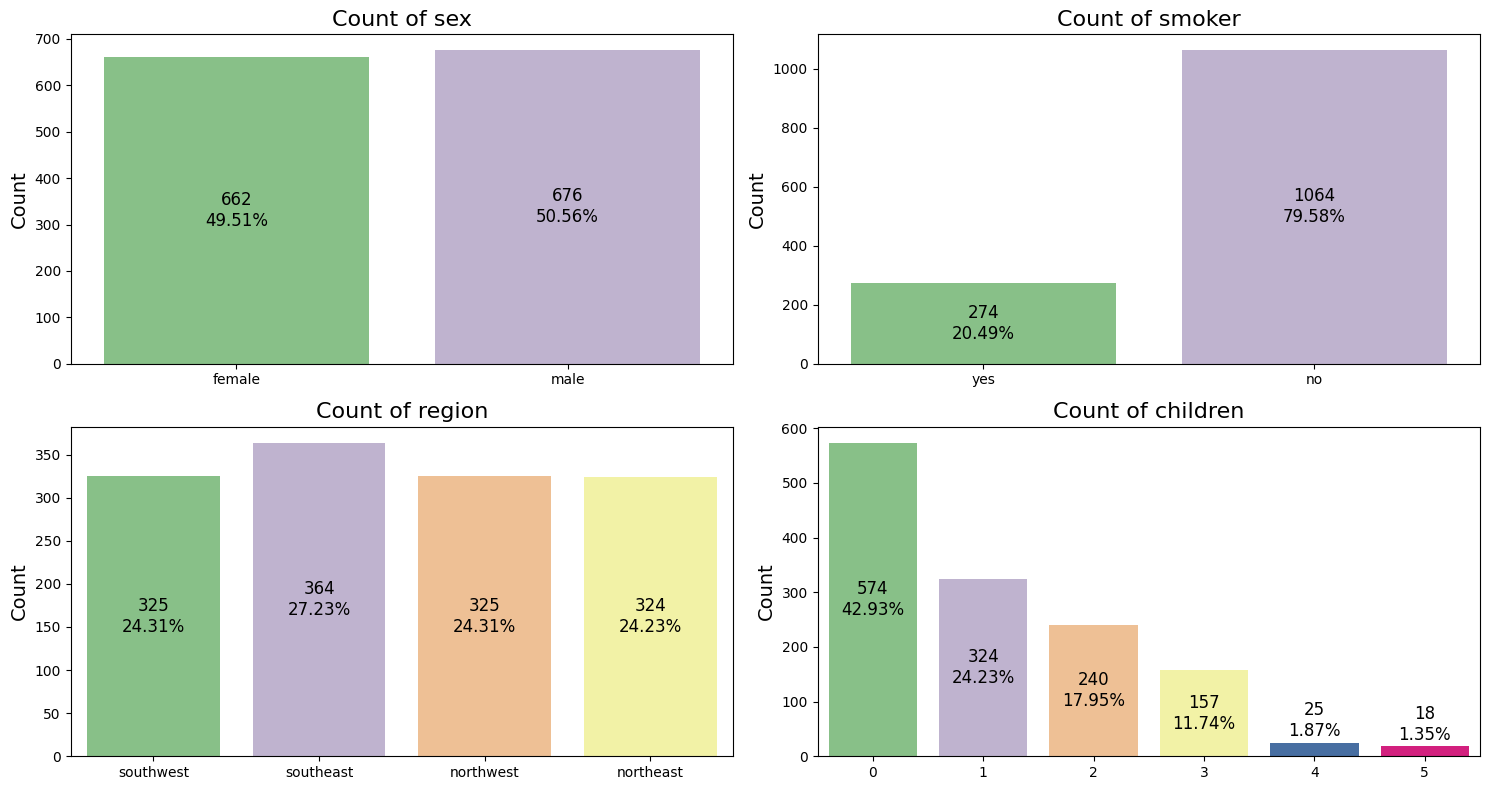

In [15]:
n_cols = 2
n_rows = (len(cat_cols) - 1) // n_cols + 1

fig, axs = plt.subplots(n_rows, n_cols, figsize = (15, 8))
axs = axs.flatten()
for n, col in enumerate(cat_cols):
    ax = sns.countplot(data=df_original, 
                       x=col,
                       ax=axs[n],
                       palette="Accent");

    for i in ax.patches: 
        if i.get_height() != 0 and i.get_height() > 50:
            ax.text(x = i.get_x() + i.get_width()/2, 
                    y = i.get_height()/2,
                    s = f'{int(i.get_height())}\n'
                        f'{i.get_height()*100/len(df):.2f}%', 
                    ha = 'center', va='center', size = 12)
        else:
            ax.text(x = i.get_x() + i.get_width()/2, 
                    y = i.get_height()+40,
                    s = f'{int(i.get_height())}\n'
                        f'{i.get_height()*100/len(df):.2f}%', 
                    ha = 'center', va='center', size = 12)

    axs[n].set_title(f"Count of {col}", fontsize=16)
    axs[n].set_xlabel(None)
    ax.set_ylabel('Count', fontsize=14)
    plt.tight_layout()

<a name="section-three"></a>
### **Numerical Analysis**

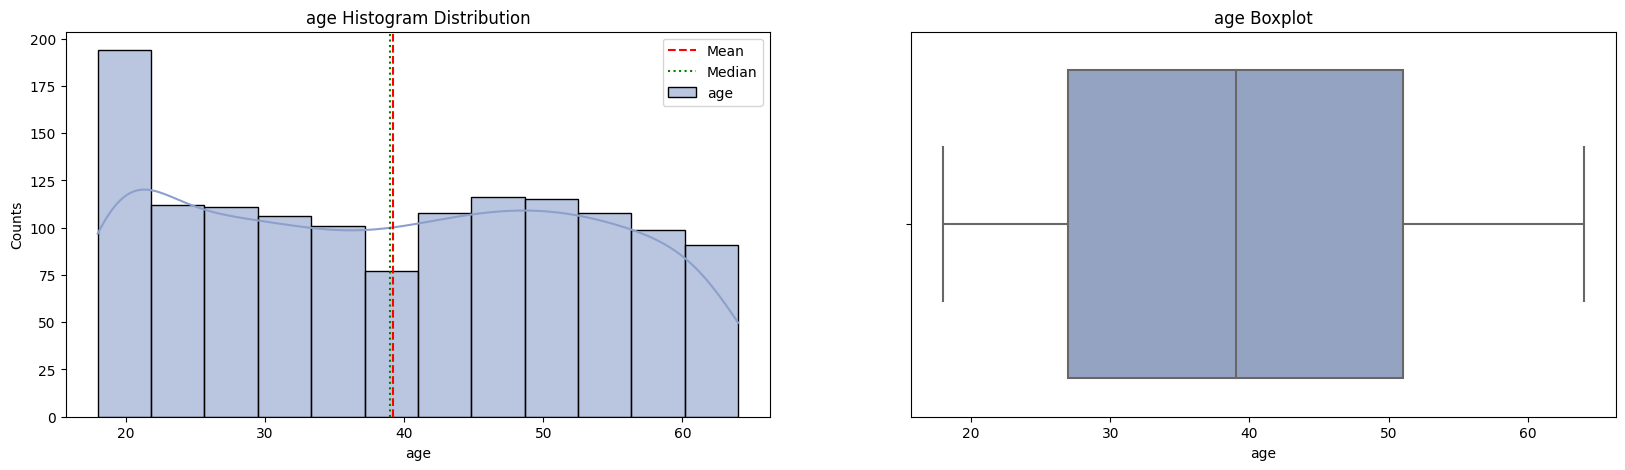

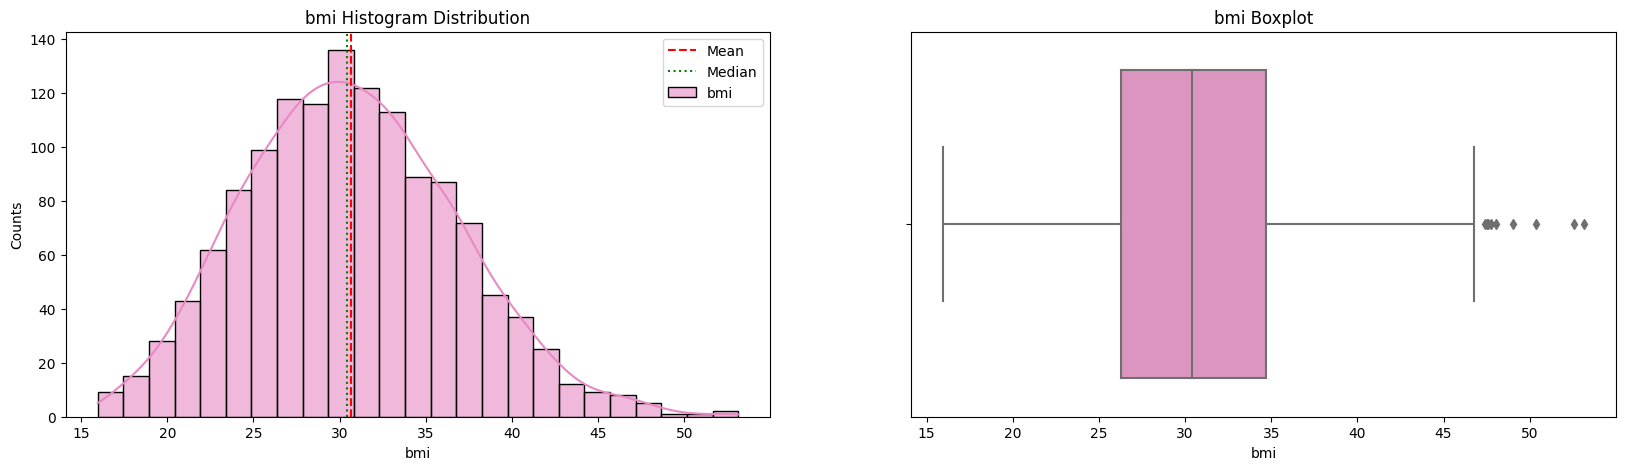

In [16]:
palette_color = sns.color_palette('Set2')

for idx, col in enumerate(df_original[num_cols], start=2):
    plt.figure(figsize=(20, 5))
    plt.subplot(1, 2, 1)
    sns.histplot(df_original[col], kde=True, label=col, 
                 alpha=0.6, color=palette_color[idx])
    plt.axvline(np.mean(df_original[col]), ls='--', c='r', label="Mean")
    plt.axvline(np.median(df_original[col]), ls=':', c='g', label="Median")
    plt.ylabel("Counts")
    plt.title(f"{col} Histogram Distribution");
    plt.legend()

    plt.subplot(1, 2, 2)
    sns.boxplot(x=df_original[col], data=df_original, color=palette_color[idx])
    plt.title(f"{col} Boxplot");

<a name="section-four"></a>
## **II. Bi-variate Analysis**
### **Categoric vs Target**

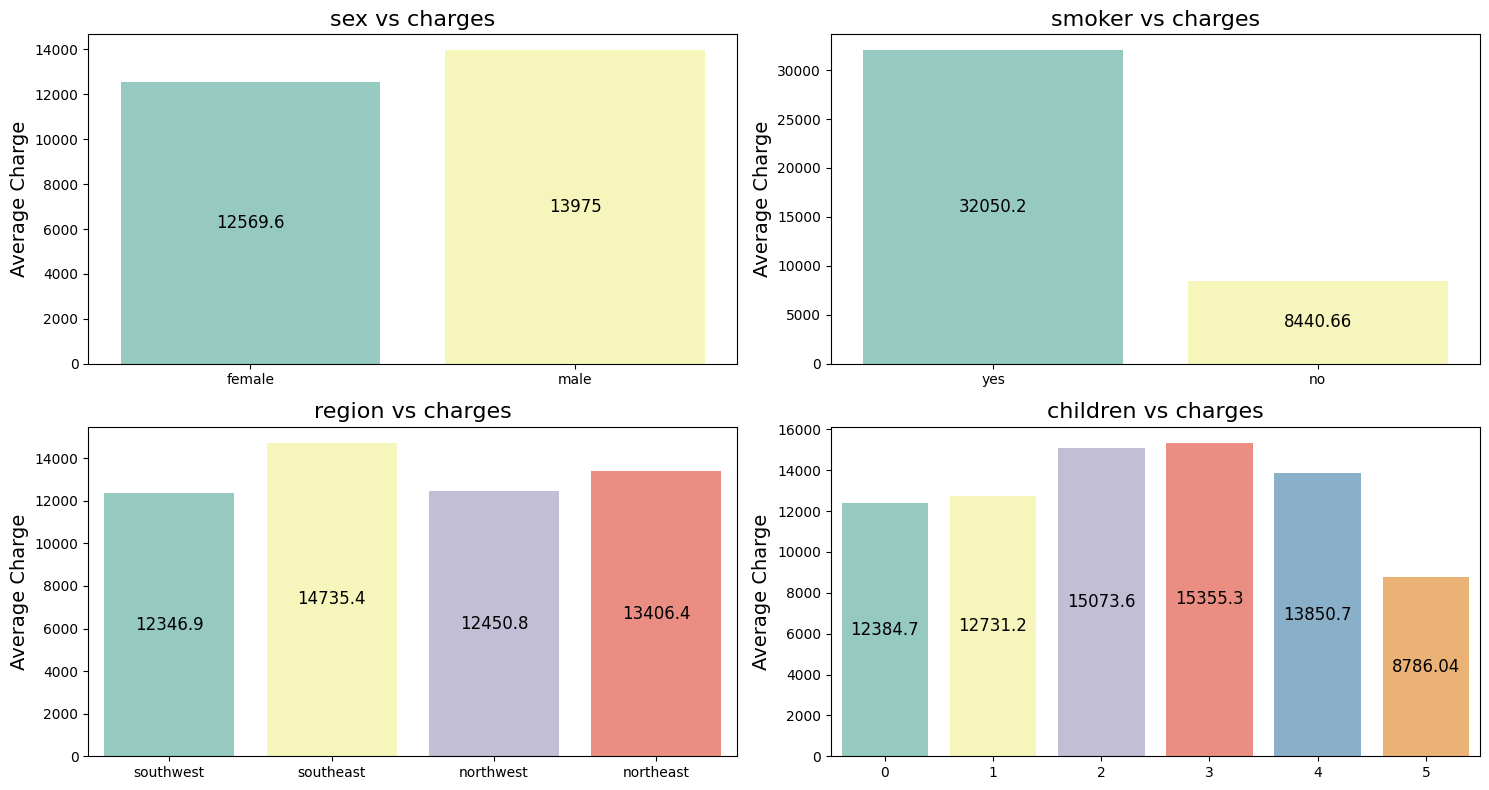

In [17]:
n_cols = 2
n_rows = (len(cat_cols) - 1) // n_cols + 1

fig, axs = plt.subplots(n_rows, n_cols, figsize = (15, 8))
axs = axs.flatten()

for n, col in enumerate(cat_cols):
    ax = sns.barplot(data=df,
                     x=df[col],
                     y=df['charges'],
                     palette="Set3",
                     ax=axs[n],
                     errorbar=None);
    
    for container in ax.containers:
        ax.bar_label(container, fontsize=12, label_type='center')
        
    axs[n].set_title(f"{col} vs charges", fontsize=16)
    axs[n].set_xlabel(None)
    ax.set_ylabel('Average Charge', fontsize=14)
    plt.tight_layout()

<a name="section-five"></a>
### **Numeric vs Target**

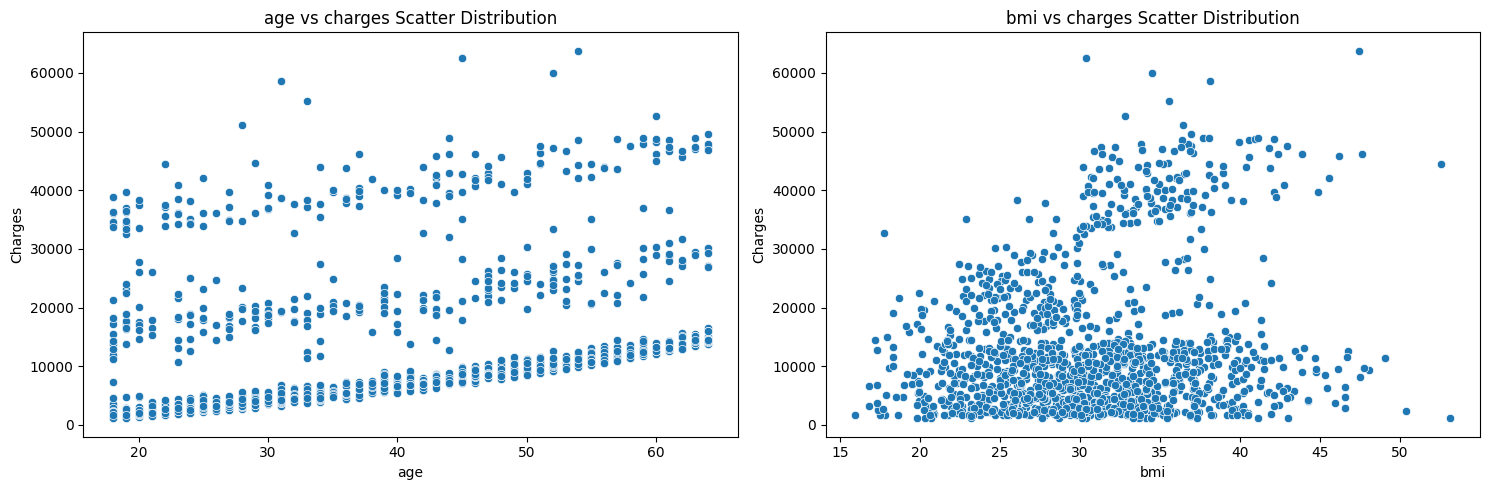

In [18]:
n_cols = 2
n_rows = (len(num_cols) - 1) // n_cols + 1

fig, axs = plt.subplots(n_rows, n_cols, figsize = (15, 5))
axs = axs.flatten()

for n, col in enumerate(num_cols):
    sns.scatterplot(data=df, 
                    x=col, 
                    y=target_col, 
                    ax=axs[n])

    axs[n].set_title(f"{col} vs {target_col} Scatter Distribution");
    axs[n].set_ylabel("Charges")
    plt.tight_layout()

<a name="section-six"></a>
# **Feature Engineering**

* 2 new categorical features were extracted from the variables "**bmi**" and "**age**".
    - "**BMI_CAT**" extracted from "bmi" has 6 unique values. These are:
        * "Underweight", "Healthy", "Overweight","Obese_Class1", "Obese_Class2" and "Obese_Class3". 
        * The number of patients is 397, 380, 226, 221, 93, 21, respectively.
    - "**Age_CAT**" extracted from "age" has 4 unique values. These are:
        * "Teen", "Adult", "Middle_Age_Adult" and "Senior_Adult". 
        * The number of patients is 546, 535, 166, 91, respectively.   
* Categorical features were encoded with LabelEncoder.

In [19]:
df['BMI_CAT'] = pd.cut(x=df['bmi'], 
                       bins=[0, 18.5, 24.9, 29.9, 34.9, 39.9,  np.inf],
                       labels=["Underweight", "Healthy", "Overweight", 
                       "Obese_Class1", "Obese_Class2", "Obese_Class3"])

df['Age_CAT'] = pd.cut(x=df['age'], 
                       bins=[13, 20, 40, 60, np.inf], 
                       labels=["Teen", "Adult", "Middle_Age_Adult", "Senior_Adult"])

cat_cols.append('BMI_CAT')
cat_cols.append('Age_CAT')

In [20]:
for col in ['BMI_CAT', 'Age_CAT']:    
    print(pd.DataFrame({"Count": df[col].value_counts(), 
                        "Ratio": 100 * df[col].value_counts() / len(df)}).to_markdown(numalign="center",
                                                                                      stralign="center"))
    print("\n")

|   BMI_CAT    |  Count  |  Ratio  |
|:------------:|:-------:|:-------:|
| Obese_Class1 |   396   | 29.6185 |
|  Overweight  |   380   | 28.4218 |
| Obese_Class2 |   226   | 16.9035 |
|   Healthy    |   221   | 16.5295 |
| Obese_Class3 |   93    | 6.95587 |
| Underweight  |   21    | 1.57068 |


|     Age_CAT      |  Count  |  Ratio  |
|:----------------:|:-------:|:-------:|
| Middle_Age_Adult |   546   | 40.8377 |
|      Adult       |   535   | 40.015  |
|       Teen       |   165   | 12.3411 |
|   Senior_Adult   |   91    | 6.80628 |




In [21]:
def encode_categorical_columns(df, columns):
    encoders = {}
    
    for col in columns:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col])
        encoders[f'le_{col}'] = le
    
    return df, encoders

df, encoders = encode_categorical_columns(df, cat_cols)

## **Train | Test Split**

In [22]:
X = df.drop('charges' , axis = 1)
y = df['charges']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

<a name="section-seven"></a>
# **Model Building**
<a name="section-eight"></a>
## **Hyper Parameter Optimization for Ensemble Models**
* Optuna was used to perform hyperparameter optimization in this project. And this optimization was done for only 3 models. These are:
    - LightGBM
    - XGBoost
    - CatBoost
    
<a name="section-nine"></a>
### **LGBM Optuna**

In [23]:
from lightgbm import LGBMRegressor
import optuna

def objective_lgbm(trial):
    params = {
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'subsample': trial.suggest_float('subsample', 0.5, 1),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 3.0, log=True),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 3.0, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 2, 256),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 100)
    }

    model = LGBMRegressor(**params)
    model.fit(X_train, y_train, eval_set=[(X_test, y_test)], early_stopping_rounds=100, verbose=False)
    return mean_squared_error(y_test, model.predict(X_test))

optuna.logging.set_verbosity(optuna.logging.WARNING)
study_lgbm = optuna.create_study(direction='minimize', study_name='LGBM Classifier')
study_lgbm.optimize(objective_lgbm, n_trials=200, show_progress_bar=True)
best_params_lgbm = study_lgbm.best_params

  0%|          | 0/200 [00:00<?, ?it/s]

<a name="section-ten"></a>
### **XGB Optuna**

In [24]:
import optuna
from xgboost import XGBRegressor

def objective_xgb(trial):
    params = {
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'subsample': trial.suggest_float('subsample', 0.5, 1),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1),
        'gamma': trial.suggest_float('gamma', 0, 0.5),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 3.0, log=True),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 3.0, log=True)
    }
    model = XGBRegressor(**params)
    model.fit(X_train, y_train, eval_set=[(X_test, y_test)], early_stopping_rounds=100, verbose=False)
    return mean_squared_error(y_test, model.predict(X_test))

optuna.logging.set_verbosity(optuna.logging.WARNING)
study_xgb = optuna.create_study(direction='minimize')
study_xgb.optimize(objective_xgb, n_trials=200, show_progress_bar=True)
best_params_xgb = study_xgb.best_params

  0%|          | 0/200 [00:00<?, ?it/s]

<a name="section-eleven"></a>
### **CatBoost Optuna**

In [25]:
from catboost import CatBoostRegressor

def objective_catboost(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 100, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'depth': trial.suggest_int('depth', 4, 10),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-8, 3.0, log=True),
        'border_count': trial.suggest_int('border_count', 32, 255),
        # 'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.1, 1),
        'bootstrap_type': trial.suggest_categorical('bootstrap_type', ['Bayesian', 'Bernoulli', 'MVS']),
        'loss_function': 'RMSE',
        'eval_metric': 'RMSE',
        # 'task_type': 'GPU',  
        'verbose': False
    }

    if params['bootstrap_type'] != 'Bayesian':
        params['subsample'] = trial.suggest_float('subsample', 0.1, 1)

    if params['bootstrap_type'] == 'Bayesian':
        params['bagging_temperature'] = trial.suggest_float('bagging_temperature', 0, 10)
    
    model = CatBoostRegressor(**params)
    model.fit(X_train, y_train, eval_set=[(X_test, y_test)], early_stopping_rounds=100, verbose=False)
    return mean_squared_error(y_test, model.predict(X_test))

optuna.logging.set_verbosity(optuna.logging.WARNING)
study_catboost = optuna.create_study(direction='minimize')
study_catboost.optimize(objective_catboost, n_trials=200, show_progress_bar=True)
best_params_catboost = study_catboost.best_params

  0%|          | 0/200 [00:00<?, ?it/s]

<a name="section-twelve"></a>
## **Build optimized models**

In [26]:
models = {'Lasso': {'model': Lasso()},
          'LinearRegression': {'model': LinearRegression()},
          'Ridge': {'model': Ridge()},
          'ElasticNet': {'model': ElasticNet()},
          # 'KNeighborsRegressor': {'model': KNeighborsRegressor()},
          'RandomForestRegressor': {'model': RandomForestRegressor()},
          'GradientBoostingRegressor': {'model': GradientBoostingRegressor()},
          'AdaBoostRegressor': {'model': AdaBoostRegressor(n_estimators = 5,
                                                           learning_rate = 1.2,
                                                           loss = 'exponential',
                                                           random_state = 2)},
          'DecisionTreeRegressor': {'model': DecisionTreeRegressor(max_depth = 9,
                                                                   min_samples_split = 4,
                                                                   random_state = 1)},
          'XGB': {'model': XGBRegressor(random_state=17,**best_params_xgb)},
          'LightGBM': {'model': LGBMRegressor(random_state=17, verbose=-1, **best_params_lgbm)},
          'CatBoost': {'model': CatBoostRegressor(verbose=False, **best_params_catboost)}}

In [27]:
df_scores = pd.DataFrame(columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2'])

for name, regressor in models.items():
    print('Running: ', name)
    regressor['model'].fit(X_train, y_train)
    y_pred = regressor['model'].predict(X_test)
    y_train_pred = regressor['model'].predict(X_train)

    mae_test = mean_absolute_error(y_test, y_pred)
    mse_test = mean_squared_error(y_test, y_pred)
    rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))
    r2_test = r2_score(y_test, y_pred)

    mae_train = mean_absolute_error(y_train, y_train_pred)
    mse_train = mean_squared_error(y_train, y_train_pred)
    rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
    r2_train = r2_score(y_train, y_train_pred)

    print('\n'.join([f'MAE  TEST:   {mae_test}',
                     f'MSE  TEST:   {mse_test}',
                     f'RMSE TEST:   {rmse_test}',
                     f'R2   TEST:   {r2_test}\n']))

    print('\n'.join([f'MAE  TRAIN:  {mae_train}',
                     f'MSE  TRAIN:  {mse_train}',
                     f'RMSE TRAIN:  {rmse_train}',
                     f'R2   TRAIN:  {r2_train}\n']))

    print("*************************\n")

    df_scores = df_scores._append({"Model": name,
                                   "MAE": mae_test,
                                   "MSE": mse_test,
                                   "RMSE": rmse_test,
                                   "R2": r2_test},
                                  ignore_index=True)

Running:  Lasso
MAE  TEST:   4231.684948316488
MSE  TEST:   36290780.217207104
RMSE TEST:   6024.182950177319
R2   TEST:   0.802505672906173

MAE  TRAIN:  4142.521490156679
MSE  TRAIN:  36509357.01743608
RMSE TRAIN:  6042.297329446481
R2   TRAIN:  0.7333422562720179

*************************

Running:  LinearRegression
MAE  TEST:   4231.179681546436
MSE  TEST:   36283487.17438346
RMSE TEST:   6023.57760590693
R2   TEST:   0.8025453616253546

MAE  TRAIN:  4142.347258638962
MSE  TRAIN:  36509342.56502534
RMSE TRAIN:  6042.296133509622
R2   TRAIN:  0.7333423618298134

*************************

Running:  Ridge
MAE  TEST:   4246.056537386484
MSE  TEST:   36460313.26766799
RMSE TEST:   6038.237596158997
R2   TEST:   0.8015830745073361

MAE  TRAIN:  4149.2637508598245
MSE  TRAIN:  36512230.53281024
RMSE TRAIN:  6042.535108115652
R2   TRAIN:  0.7333212686351807

*************************

Running:  ElasticNet
MAE  TEST:   7910.220966214429
MSE  TEST:   111749143.67653106
RMSE TEST:   10571.1

In [28]:
def highlight_max(s, props='background-color:lightgreen;'):
    return np.where(s == np.nanmax(s.values), props, '')

def highlight_min(s, props='background-color:red;'):
    return np.where(s == np.nanmin(s.values), props, '')

df_scores.style.apply(highlight_max, subset=['R2'])\
.apply(highlight_min, subset=['MAE', 'MSE', 'RMSE'])

,Model,MAE,MSE,RMSE,R2
0,Lasso,4231.684948,36290780.217207,6024.182950,0.802506
1,LinearRegression,4231.179682,36283487.174383,6023.577606,0.802545
2,Ridge,4246.056537,36460313.267668,6038.237596,0.801583
3,ElasticNet,7910.220966,111749143.676531,10571.146753,0.391861
4,RandomForestRegressor,2654.957178,21964350.033918,4686.613920,0.880470
5,GradientBoostingRegressor,2499.438465,18030772.257622,4246.265684,0.901877
6,AdaBoostRegressor,4559.882765,29937720.039773,5471.537265,0.837079
7,DecisionTreeRegressor,2821.920171,32142553.711547,5669.440335,0.825080
8,XGB,2918.521119,22262398.624345,4718.304635,0.878848
9,LightGBM,2853.896035,20568295.115115,4535.228232,0.888067


<a name="section-thirteen"></a>
## **Compare Models**

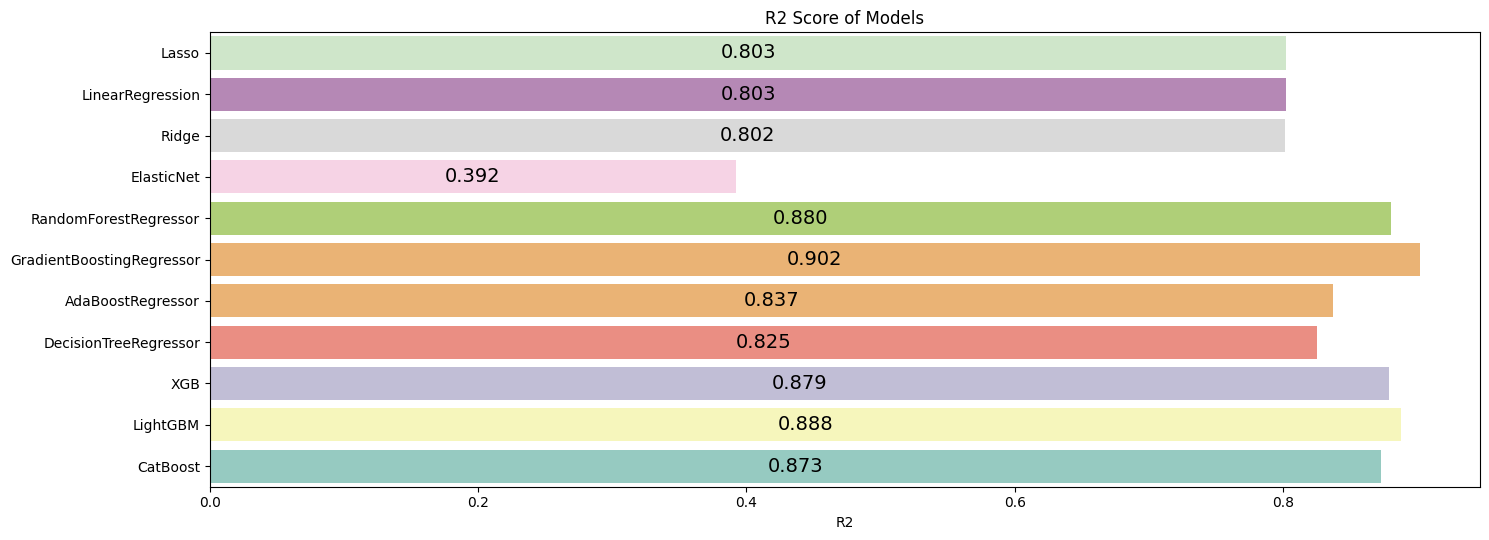

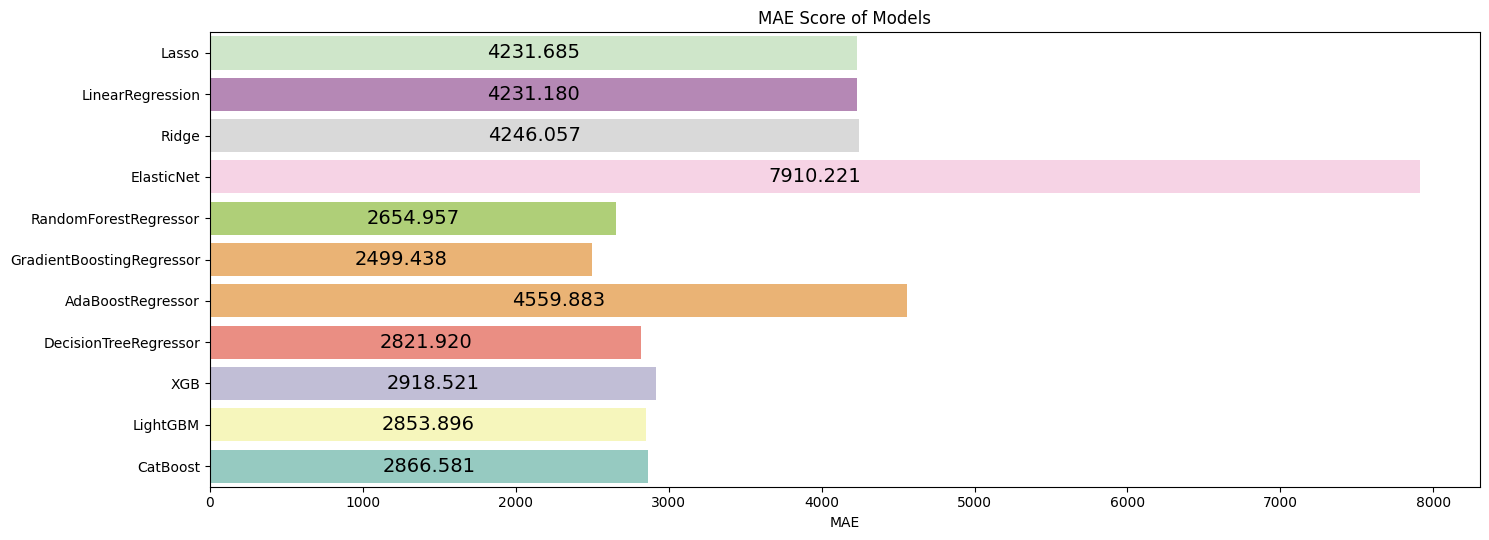

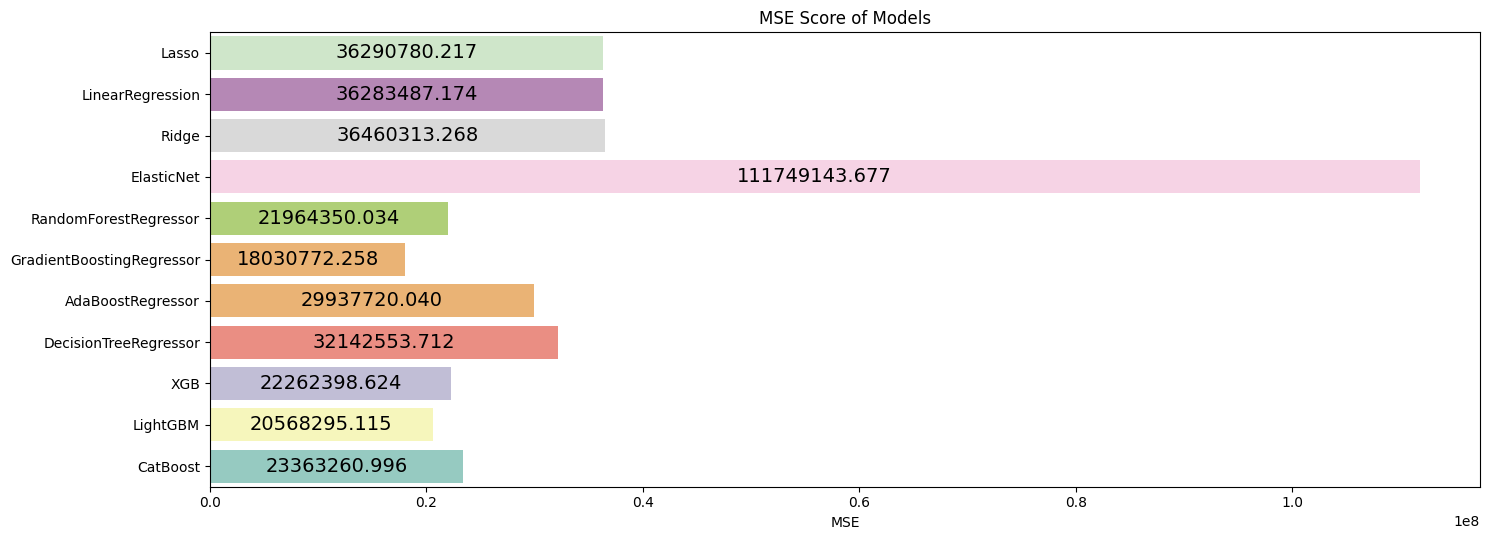

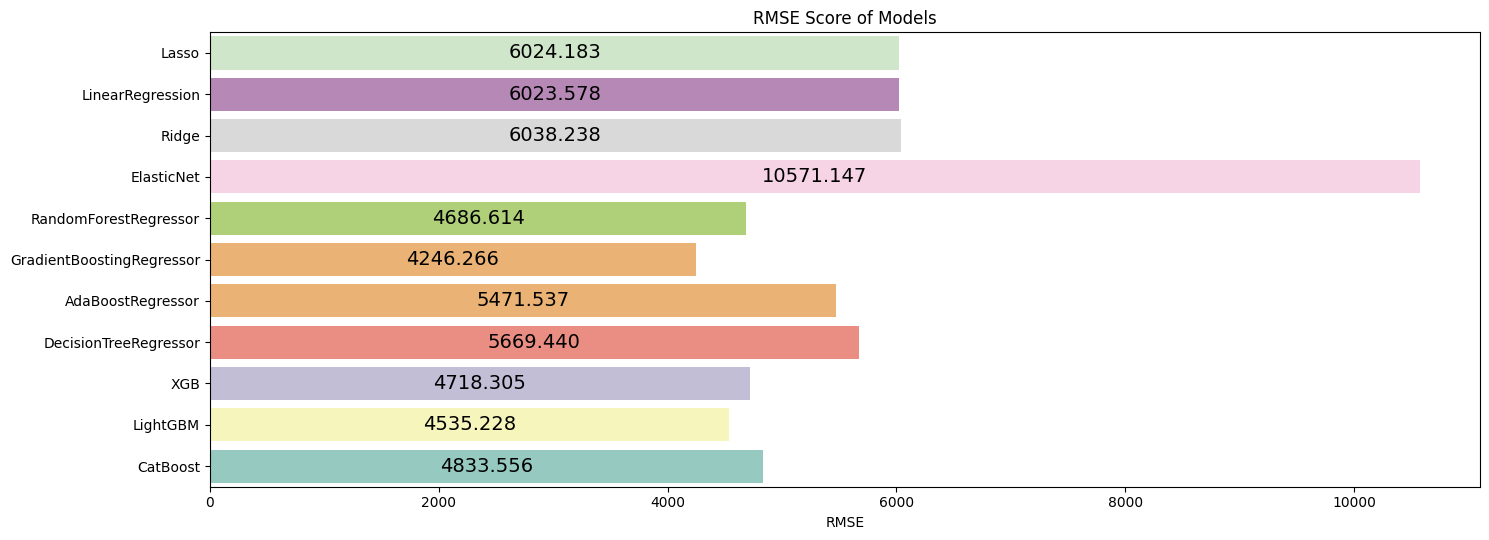

In [29]:
for col in df_scores[['R2', 'MAE', 'MSE', 'RMSE']]:
    plt.figure(figsize=(15, 5.5))
    ax = sns.barplot(data=df_scores, x=col, y='Model', palette="Set3_r");

    for container in ax.containers:
        ax.bar_label(container,  fmt='{:1.3f}',
                     fontsize=14,  label_type='center')
    ax.set(ylabel='')
    plt.title(f'{col} Score of Models')
    plt.tight_layout()

<a name="section-fourteen"></a>
# **Final Model**

* **GradientBoostingRegressor** was chosen as the best/final model after examining the test and training scores.

In [30]:
final_model = GradientBoostingRegressor()

scores = cross_val_score(final_model, X, y, cv=5, scoring=make_scorer(r2_score))
print(f"R2 Score: {np.mean(scores):.4f} (+/- {np.std(scores):.4f})")

scores_mae = -cross_val_score(final_model, X, y, cv=5, scoring='neg_mean_absolute_error')
print(f"MAE: {np.mean(scores_mae):.4f} (+/- {np.std(scores_mae):.4f})")

scores_mse = -cross_val_score(final_model, X, y, cv=5, scoring='neg_mean_squared_error')
print(f"MSE: {np.mean(scores_mse):.4f} (+/- {np.std(scores_mse):.4f})")

scores_rmse = np.sqrt(-cross_val_score(final_model, X, y, cv=5, scoring='neg_mean_squared_error'))
print(f"RMSE: {np.mean(scores_rmse):.4f} (+/- {np.std(scores_rmse):.4f})")

R2 Score: 0.8555 (+/- 0.0311)
MAE: 2495.6252 (+/- 165.9762)
MSE: 20961877.1838 (+/- 3364683.1959)
RMSE: 4567.4242 (+/- 376.3840)


<a name="section-fifteen"></a>
## **Feature Importance with SHAP**

* SHAP — which stands for Shapley Additive exPlanations, is an algorithm that was first published in 2017, and it is a great way to reverse-engineer the output of any black-box models. 
* SHAP is a framework that provides computationally efficient tools to calculate Shapley values - a concept in cooperative game theory that dates back to 1950.
* SHAP feature importance is an alternative to permutation feature importance. There is a big difference between both importance measures: Permutation feature importance is based on the decrease in model performance. SHAP is based on magnitude of feature attributions
* **Advantage**: Since SHAP computes Shapley values, all the advantages of Shapley values apply: SHAP has a solid theoretical foundation in game theory. The prediction is fairly distributed among the feature values. We get contrastive explanations that compare the prediction with the average prediction.

**Shapley values can help you in:**

* Global model interpretability
    - Bar Plot
    - Beeswarm
* Local interpretability: explaining why the model got to a particular decision for a sample.
    - Waterfall
    - Force Plot


In [31]:
final_model = GradientBoostingRegressor().fit(X, y)

explainer = shap.TreeExplainer(final_model)
shap_values = explainer.shap_values(X)

Here is how to interpret the below bar plot:
* Passing a matrix of SHAP values to the bar plot function creates a global feature importance plot, where the global importance of each feature is taken to be the mean absolute value for that feature over all the given samples.

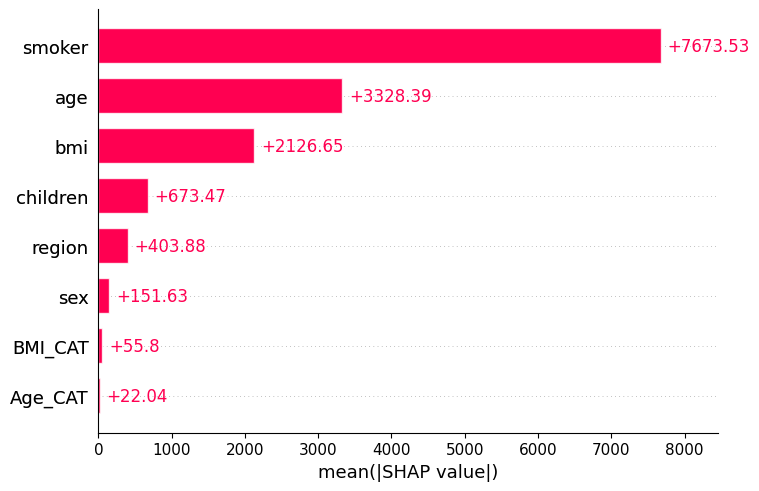

In [32]:
shap_values = explainer(X)
shap.plots.bar(shap_values)

Here is how to interpret the below summary plot (beeswarm):
* The summary plot combines feature importance with feature effects. Each point on the summary plot is a Shapley value for a feature and an instance.
* The left vertical axis denotes feature names, ordered based on importance from top to bottom.
* The horizontal axis represents the magnitude of the SHAP values for predictions.
* The vertical right axis represents the actual magnitude of a feature as it appears in the dataset and colors the points

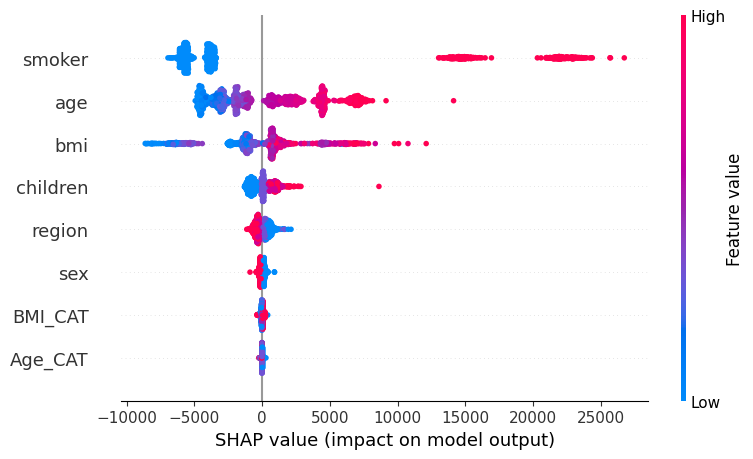

In [33]:
shap.summary_plot(shap_values, X)

Here is how to interpret the below waterfall plot:

* The `E[f(x)] = 13279.121` is the mean prediction of medical cost for the whole dataset. 
* The `f(x) = 5385.584` is the predicted charge for the medical visit. 
* The thin line in the middle denotes the mean prediction. 
* The vertical axis shows the feature values of the 203rd medical visit. 
* The bars represent how each feature property shifted the price from the mean prediction. 
    - The red bars represent positive shifts; the blue bars represent negative shifts.

In [34]:
random_idx = np.random.randint(len(X))
print("Random Person: {}".format(random_idx))
print("Actual Charge: {}".format(y[y.index==random_idx].values[0]))

Random Person: 222
Actual Charge: 5253.524


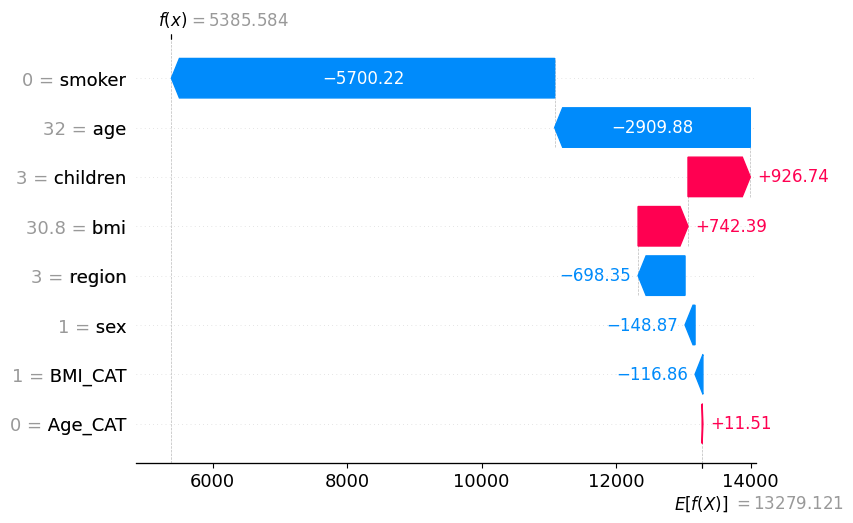

In [35]:
shap.waterfall_plot(shap_values[random_idx])

<a name="section-sixteen"></a>
## **Save Final Model**

In [36]:
final_model.fit(X, y)
joblib.dump(final_model, 'final_model_gb.pkl')

['final_model_gb.pkl']